Notebook for creating signatures from the squiggles by:
- Getting the sequence of differences above a certain threshold.
    - Comparing these sequences.
- Taking the means of the actual values under the plateaus.
    - Comparing these sequences.

In [1]:
import time
from ont_fast5_api.fast5_interface import get_fast5_file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import h5py
import operator
import json


In [2]:
def loadReads(f5_file="../../similar_testdata/similar_squiggles.fast5", withMetadata=False):
    '''
        returns list of numpy arrays representing reads as well as dataframe containing reads metadata.
    '''
    print("reading squiggles file...")
    start = time.time()
    reads = []
    if withMetadata:
        ids = []
        length = []
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
                ids.append(read.read_id)
                length.append(len(raw_data))

        z = list(zip(ids, length))
        print(f"Took {time.time()-start} seconds.\n")
        return reads, pd.DataFrame(z, columns=["id", "length"])

    else:
        with get_fast5_file(f5_file, mode="r") as f5:
            for read in f5.get_reads():
                raw_data = read.get_raw_data()
                reads.append(raw_data)
        print(f"Took {time.time()-start} seconds.\n")
        return reads

In [3]:
def removeSpikes(sequence, spikeThresh=3):
    # print("removing spikes")
    # start = time.time()
    
    #spikeThresh = 2000
    returnList = [i for i in sequence if abs(i) < spikeThresh]
    # print(f"Took {time.time()-start} seconds.\n")

    return returnList

In [4]:
def zScoreNormalise(sequence):
    # print("z-score normalising")
    # start = time.time()
    
    zScoreNormalised = np.zeros(len(sequence))
    mean = np.mean(sequence)
    standardDev = np.std(sequence)
    zScoreNormalised = (sequence - mean) / standardDev
    # print(f"Took {time.time()-start} seconds.\n")

    return zScoreNormalised

In [5]:
def getDifferences(sequence, thresh=0.2):
    differencesPlateaus = [0]

    for i in range(len(sequence)-1):
        dif = abs(sequence[i+1] - sequence[i])
        if dif > thresh:
            differencesPlateaus.append(dif)
        else:
            differencesPlateaus.append(differencesPlateaus[i])


    means = []
    startI = 0
    for i in range(1, len(sequence)):
        if differencesPlateaus[i] != differencesPlateaus[i-1]:
            means.append(np.mean(sequence[startI:i]))
            startI = i
            
    if startI != len(sequence)-1:
        means.append(np.mean(sequence[startI:len(sequence)-1]))


    return differencesPlateaus, means


In [6]:
allSquiggles, metadata = loadReads(withMetadata=True)

reading squiggles file...
Took 4.379240989685059 seconds.



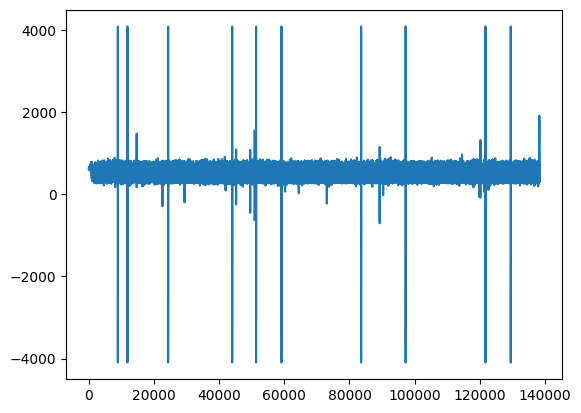

In [7]:
squig = allSquiggles[3].copy()
fig = plt.figure()
plt.plot(squig)

plt.show()

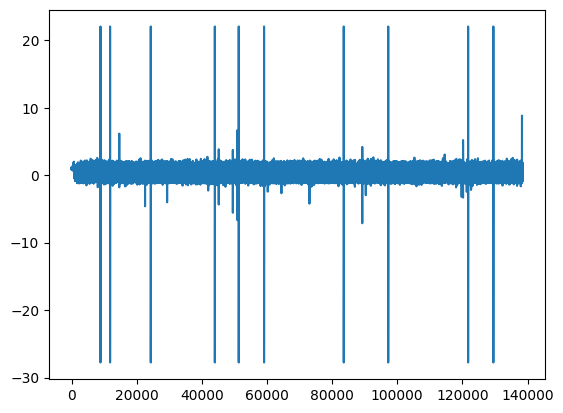

In [8]:
squig = zScoreNormalise(squig)
fig = plt.figure()
plt.plot(squig)

plt.show()

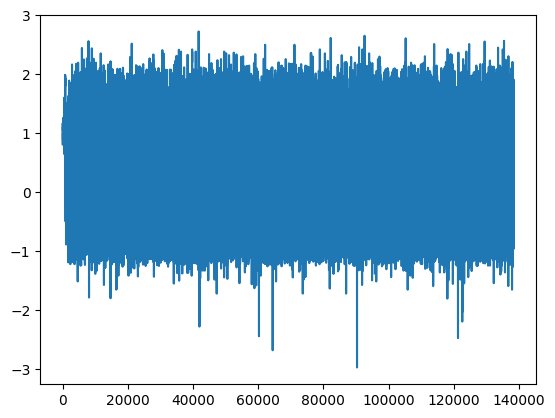

In [9]:
squig = removeSpikes(squig)
fig = plt.figure()
plt.plot(squig)

plt.show()

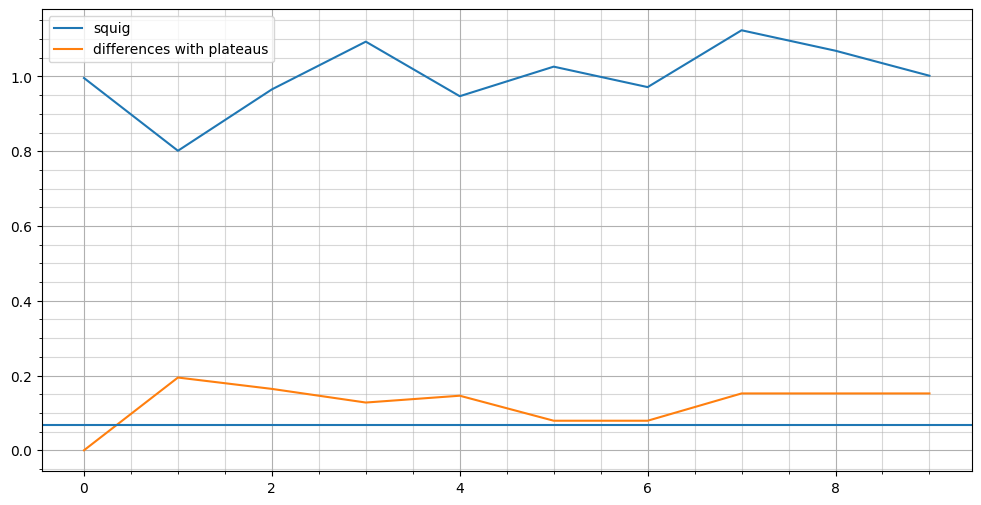

In [13]:
thresh = 0.0625+(0.0625*0.1)


diffP = getDifferences(squig, thresh)


max = 100

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(squig[0:10], label="squig")
ax.plot(diffP[0:10], label="differences with plateaus")
#ax.plot(actualDif[0:max], label="differences")
ax.axhline(thresh)
ax.minorticks_on()
ax.grid(which = "minor", alpha = 0.5)
ax.grid()
ax.legend()

In [7]:
def getDifferenceSignatures(squiggles, path="../../difference_signatures/"):
    batchSize = 4000#200
    lastBatch = False
    batchNo = 0
    totalSquiggleCount = len(squiggles)
    totalBatches = math.floor(totalSquiggleCount/batchSize)
    start = time.time()
    while not lastBatch:
        print(f"Batch {batchNo} / {totalBatches}")
        if batchNo == totalBatches:
            lastBatch = True
            batch = squiggles[batchNo*batchSize:]
        else:
            batch = squiggles[batchNo*batchSize:(batchNo+1)*batchSize]

        
        fMeans = h5py.File(f"{path}plateaus-mean-batch{batchNo}.hdf5", "a")
        fPlateaus = h5py.File(f"{path}plateaus-batch{batchNo}.hdf5", "a")

        dt = h5py.vlen_dtype(np.dtype("float16"))                           #non-normalised data stored as int16 so only need 16 bits of precision.
        plateausDset = fPlateaus.create_dataset(f"vectors{batchNo}", (len(batch),), dtype=dt)
        meansDset = fMeans.create_dataset(f"vectors{batchNo}", (len(batch),), dtype=dt)


        for i in range(len(batch)):
            sig = zScoreNormalise(batch[i])
            plat, means = getDifferences(sig)
            plateausDset[i] = plat
            meansDset[i] = means
            print(f"(Batch {batchNo}) - squiggle {i+(batchNo*batchSize)} / {totalSquiggleCount}")

        fPlateaus.close()
        fMeans.close()

        batchNo += 1
    print(f"Took {time.time()-start} seconds.\n")


In [9]:
getDifferenceSignatures(allSquiggles)

Batch 0 / 0
(Batch 0) - squiggle 0 / 3760
(Batch 0) - squiggle 1 / 3760
(Batch 0) - squiggle 2 / 3760
(Batch 0) - squiggle 3 / 3760
(Batch 0) - squiggle 4 / 3760
(Batch 0) - squiggle 5 / 3760
(Batch 0) - squiggle 6 / 3760
(Batch 0) - squiggle 7 / 3760
(Batch 0) - squiggle 8 / 3760
(Batch 0) - squiggle 9 / 3760
(Batch 0) - squiggle 10 / 3760
(Batch 0) - squiggle 11 / 3760
(Batch 0) - squiggle 12 / 3760
(Batch 0) - squiggle 13 / 3760
(Batch 0) - squiggle 14 / 3760
(Batch 0) - squiggle 15 / 3760
(Batch 0) - squiggle 16 / 3760
(Batch 0) - squiggle 17 / 3760
(Batch 0) - squiggle 18 / 3760
(Batch 0) - squiggle 19 / 3760
(Batch 0) - squiggle 20 / 3760
(Batch 0) - squiggle 21 / 3760
(Batch 0) - squiggle 22 / 3760
(Batch 0) - squiggle 23 / 3760
(Batch 0) - squiggle 24 / 3760
(Batch 0) - squiggle 25 / 3760
(Batch 0) - squiggle 26 / 3760
(Batch 0) - squiggle 27 / 3760
(Batch 0) - squiggle 28 / 3760
(Batch 0) - squiggle 29 / 3760
(Batch 0) - squiggle 30 / 3760
(Batch 0) - squiggle 31 / 3760
(Batch

In [10]:
def getSimilarity(squig1, squig2):
    sim = np.correlate(squig1, squig2)
    return(1*np.max(sim))                   #hacky workaround - doing 1 * similarity converts to 64-bit float (serialisable by json)

In [11]:
#for each squiggle:
#   compare to every other squiggle
#   make a note of the maximum similarity found from cross correlation with every other squiggle
#   return dictionary of squiggle: similarity score
#   store the top 10 for each squiggle

f = h5py.File("../../difference_signatures/plateaus-mean-batch0.hdf5", "r")
savePath = "../../correlation_compared/plateaus_mean/"

data = f["vectors0"]
ids = metadata["id"].tolist()
#print(metadata["id"].tolist())
print(len(ids))
print(len(data))

similarities = {}
for i in range(len(ids)):
    print(f"Dataset sweep for squiggle {ids[i]} ({i}/{len(ids)})")
    similarities[ids[i]] = {}
    for j in range(len(ids)):
        print(j)
        similarities[ids[i]][ids[j]] = getSimilarity(data[i], data[j])
        
    s = dict(sorted(similarities[ids[i]].items(), key=operator.itemgetter(1), reverse=True)[:10])     #saves just the top 10 most similar
    with open(f"{savePath}{ids[i]}.json", "w") as jsonFile:
        jsonFile.write(json.dumps(s))

#with open(f"{savePath}00_allSquiggles.json", "w") as jsonFile:
#    jsonFile.write(json.dumps(similarities))



3760
3760
Dataset sweep for squiggle 00014eb4-4e2c-4087-ac24-57dea735b7b4 (0/3760)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256

KeyboardInterrupt: 